This ipython notebook demonstrates how to calculate photometric (optimal psf-weighted) SNR for sources observed with LSST. 

It uses the LSST [throughputs](https://github.com/lsst/throughputs) curves, together with the LSST [sims_photUtils](https://stash.lsstcorp.org/projects/SIM/repos/sims_photutils/browse) package, to calculate the SNR for any spectrum. 

With an eye toward turning this into a more generalized SNR calculator, an overview of the process (starting from the spectrum) is:
* Set the desired magnitude (in a standardized throughput curve) for the source.
* Generate the throughput curves in all filters, for the airmass desired.
* Set the sky SED (for now we just use dark, zenith sky).
* Calculate the SNR. 

---

This notebook assumes that the `throughputs` and `sims_photUtils` packages have been installed and setup. We can then import the necessary packages:

In [1]:
from __future__ import print_function
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from lsst.sims.photUtils import Bandpass
from lsst.sims.photUtils import Sed
from lsst.sims.photUtils import SignalToNoise
from lsst.sims.photUtils import PhotometricParameters

---
<b>Read in the spectra.</b> 

I put together a few SEDs that cover a fairly wide range: elliptical and spiral galaxies, blue and red stars, and a quasar. We'll read them all into `Sed` objects, and set the quasar to have a redshift of 3.5. These SEDS are available as a [tar ball](http://www.astro.washington.edu/users/lynnej/sample_seds.tar.gz). 
Wherever you place this directory, set `sedDir` to point to that location. 

In [2]:
sedDir = '/Users/lynnej/seds/sample_seds'
filenames = !ls $sedDir
print(filenames)

['Ell2_template_norm.sed.dat', 'Sa_template_norm.sed.dat', 'Sdm_template_norm.sed0.dat', 'km10_4500.fits_g45', 'km10_5250.fits_g45', 'km10_6000.fits_g45', 'km10_6500.fits_g45', 'km10_7250.fits_g45', 'm3.0Full.dat', 'quasar.dat']


In [3]:
# Now we'll read in each of those individual seds, into a Sed object. We'll also redshift the quasar.
seds = {}
z=3.5
for s in filenames:
    seds[s] = Sed()
    seds[s].readSED_flambda(os.path.join(sedDir, s))
if 'quasar.dat' in seds:
    seds['quasar.dat'].redshiftSED(z)

---
<b>Read the standard throughput curves</b>.

First, get the names of the directories containing the baseline throughput curves and a set of standard atmosphere curves at a range of airmass (also from the throughputs package). We'll also take a peek at the contents of these directories, in case you haven't seen them before.

In [4]:
throughputsDir = os.getenv('LSST_THROUGHPUTS_BASELINE')
atmosDir = os.path.join(os.getenv('THROUGHPUTS_DIR'), 'atmos')
!ls -l $throughputsDir
#!ls -l $atmosDir
filterlist = ('u', 'g', 'r', 'i', 'z', 'y')
filtercolors = {'u':'b', 'g':'c', 'r':'g', 'i':'y', 'z':'r', 'y':'m'}

total 7160
-rw-r--r--  1 lynnej  staff   52985 Aug  2 16:16 LSSTfilters.png
-rw-r--r--  1 lynnej  staff    5720 May  3 12:24 README.md
-rw-r--r--  1 lynnej  staff  179331 May  3 12:24 atmos_10.dat
-rw-r--r--  1 lynnej  staff  173902 May  3 12:24 atmos_std.dat
-rw-r--r--  1 lynnej  staff  170296 May  3 12:24 darksky.dat
-rw-r--r--  1 lynnej  staff  149408 May  3 12:24 detector.dat
-rw-r--r--  1 lynnej  staff  106649 May  3 12:24 filter_g.dat
-rw-r--r--  1 lynnej  staff  104043 May  3 12:24 filter_i.dat
-rw-r--r--  1 lynnej  staff  105365 May  3 12:24 filter_r.dat
-rw-r--r--  1 lynnej  staff   98123 May  3 12:24 filter_u.dat
-rw-r--r--  1 lynnej  staff  107815 May  3 12:24 filter_y.dat
-rw-r--r--  1 lynnej  staff  101689 May  3 12:24 filter_z.dat
-rw-r--r--  1 lynnej  staff  106630 May  3 12:24 hardware_g.dat
-rw-r--r--  1 lynnej  staff  104019 May  3 12:24 hardware_i.dat
-rw-r--r--  1 lynnej  staff  105283 May  3 12:24 hardware_r.dat
-rw-r--r--  1 lynnej  staff   98561 May  3 12:24 hard

Read in the set of throughput curves we'll use as our "standard". These are the 'standard' LSST total throughput curves and use an X=1.2 atmosphere (with aerosols) together with the standard hardware components (with time-average losses). 

In [5]:
lsst_std = {}
for f in filterlist:
    lsst_std[f] = Bandpass()
    lsst_std[f].readThroughput(os.path.join(throughputsDir, 'total_'+f+'.dat'))

---
<b>Set the desired magnitude.</b>

Use these standard throughput curves to set the desired magnitude for each SED in the desired reference bandpass. This is the step where the user decides the magnitude of the source they want to use to calculate SNR.

In [6]:
stdFilter = 'r'
stdMag = 24.0
for s in seds:
    fluxNorm = seds[s].calcFluxNorm(stdMag, lsst_std[stdFilter])
    seds[s].multiplyFluxNorm(fluxNorm)

Pretty plot #1: plot the SEDs.

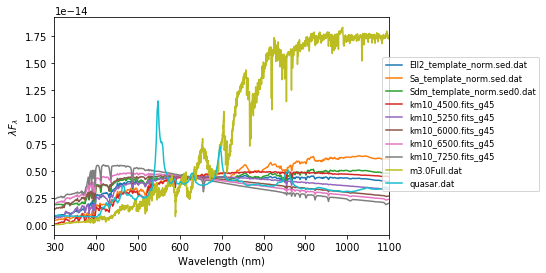

In [7]:
for s in seds:
    plt.plot(seds[s].wavelen, seds[s].flambda*seds[s].wavelen, label='%s' %(s))
plt.xlabel('Wavelength (nm)')
plt.ylabel('$\lambda F_\lambda$')
plt.xlim(300, 1100)
plt.legend(loc=(0.98, 0.2), fontsize='smaller', numpoints=1, fancybox=True)

---
<b>Read in the (non-standard) throughput components</b>

Read in the various components that we will need, in order to generate the non-standard throughput curves at arbitrary airmass. 
First, the system hardware throughput components, as we will need the hardware alone to calculate SNR anyway. (see [note (1)](#hardware_sky) below for more information). 

In [8]:
lsst_system = {}
for f in filterlist:
    lsst_system[f] = Bandpass()
    lsst_system[f].readThroughputList(['detector.dat', 'lens1.dat', 'lens2.dat', 'lens3.dat', 
                                       'm1.dat', 'm2.dat', 'm3.dat', 'filter_'+f+'.dat'], 
                                        rootDir=throughputsDir)

Then read in the atmosphere, so we can multiply it into the system hardware throughputs. This lets us generate the total throughput curves, using a wider variety of atmosphere curves at varying airmass. (The standard total throughput curves use X=1.2, for now we'll use X=1.0 here).

In [9]:
atmosphere = Bandpass()
X = 1.0
atmosphere.readThroughput(os.path.join(atmosDir, 'atmos_%d.dat' %(X*10)))

Calculate the total (non-standard) throughput curves, including the atmosphere. 

In [10]:
lsst_total = {}
for f in filterlist:
    wavelen, sb = lsst_system[f].multiplyThroughputs(atmosphere.wavelen, atmosphere.sb)
    lsst_total[f] = Bandpass(wavelen=wavelen, sb=sb)

Pretty plot #2, plot the throughput curves + atmosphere.  The dotted lines are the hardware-only throughputs, the solid lines are total system throughputs including atmosphere.

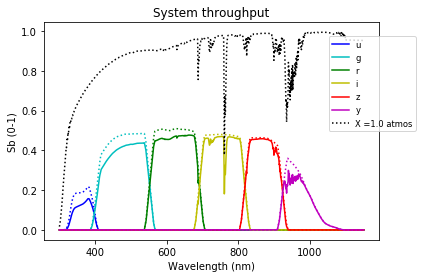

In [11]:
for f in filterlist:
    plt.plot(lsst_total[f].wavelen, lsst_total[f].sb,  linestyle='-', color=filtercolors[f], label='%s' %(f))
    plt.plot(lsst_system[f].wavelen, lsst_system[f].sb, linestyle=':', color=filtercolors[f])
plt.plot(atmosphere.wavelen, atmosphere.sb, 'k:', label='X =%.1f atmos' %(X))
plt.legend(loc=(0.85, 0.5), fontsize='smaller', fancybox=True, numpoints=1)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Sb (0-1)')
plt.title('System throughput')

---
<b>Calculate SNR</b>

The SNR of a source depends on the sky background, as well as properties of the telescope and camera. We can use the default values for LSST telescope and camera properties automatically. At the moment, the only sky spectrum we have easily available is the dark sky zenith spectrum, from the [$LSST_THROUGHPUTS_BASELINE/darksky.dat](https://github.com/lsst/throughputs/blob/master/baseline/darksky.dat) file. This spectra is calibrated to have the appropriate magnitudes in the LSST bandpasses under dark sky, zenith conditions.

In [12]:
darksky = Sed()
darksky.readSED_flambda(os.path.join(throughputsDir, 'darksky.dat'))

Calculate the SNR, assuming optimal measurement over the PSF. This means we can choose the PSF as well.<br>
`Sed` method `calcSNR_psf` accepts an instantiation of the `PhotometricParameters` class, which carries values for readnoise, platescale, gain, number of exposures, etc, set to defaults appropriate for general LSST purposes (and assuming 30 second visits, consisting of two 15 second exposures). 

In [13]:
# Set up the photometric parameters for LSST
photParams = PhotometricParameters(gain=1)
# Set up the seeing. "seeing" traditional = FWHMgeom in our terms 
#  (i.e. the physical size of a double-gaussian or von Karman PSF)
# But we use the equivalent FWHM of a single gaussian in the SNR calculation, so convert.
seeing = 0.7
FWHMeff = SignalToNoise.FWHMgeom2FWHMeff(seeing)

In [14]:
# We can investigate the SNR calculation a little closer for a single object, let's use the Mdwarf.
s = 'm3.0Full.dat'
f = 'r'
print("SNR in %s band" % f)
_ = SignalToNoise.calcSNR_sed(seds[s], lsst_total[f], darksky, lsst_system[f], photParams, FWHMeff, verbose=True)
print('')
f = 'z'
print("SNR in %s band" % f)
_ = SignalToNoise.calcSNR_sed(seds[s], lsst_total[f], darksky, lsst_system[f], photParams, FWHMeff, verbose=True)

SNR in r band
For Nexp 2.0 of time 15.0: 
Counts from source: 1387.43  Counts from sky: 796.16
FWHMeff: 0.79('')  Neff pixels: 35.205(pix)
Noise from sky: 28.22 Noise from instrument: 12.27
Noise from source: 37.25
 Total Signal: 1387.43   Total Noise: 186.32    SNR: 7.45

SNR in z band
For Nexp 2.0 of time 15.0: 
Counts from source: 3617.92  Counts from sky: 1687.89
FWHMeff: 0.79('')  Neff pixels: 35.205(pix)
Noise from sky: 41.08 Noise from instrument: 12.27
Noise from source: 60.15
 Total Signal: 3617.92   Total Noise: 261.42    SNR: 13.84


In [15]:
# Calculate SNR for all seds in all filters.
snr = pd.DataFrame(index=seds, columns=filterlist)
for i, s in enumerate(seds):
    for f in filterlist:
        snr.iloc[i][f] = SignalToNoise.calcSNR_sed(seds[s], lsst_total[f], darksky, lsst_system[f], 
                                                   photParams, FWHMeff=FWHMeff, verbose=False)
pd.set_option('precision', 3)
display(snr)

,u,g,r,i,z,y
Ell2_template_norm.sed.dat,0.755,7.53,7.46,5.71,3.78,1.79
Sa_template_norm.sed.dat,0.45,6.1,7.46,6.5,4.88,2.53
Sdm_template_norm.sed0.dat,1.16,8.17,7.46,5.84,4.1,2.05
km10_4500.fits_g45,0.307,5.57,7.45,6.34,4.21,1.95
km10_5250.fits_g45,0.741,7.22,7.46,5.66,3.49,1.53
km10_6000.fits_g45,1.26,8.56,7.46,5.23,3.06,1.29
km10_6500.fits_g45,1.52,9.38,7.46,4.99,2.84,1.17
km10_7250.fits_g45,1.76,10.5,7.46,4.66,2.53,1.03
m3.0Full.dat,0.15,3.53,7.45,14.4,13.8,7.1
quasar.dat,0.4,6.28,7.46,5.38,3.32,1.34


Note that the SNR in the r band is the same for all of these objects. This makes sense, as we normalized them all to have the same r band standard magnitudes, and the X=1.0 atmosphere is not hugely different from the X=1.2 standard throughput curves.  However, their SNR in other bandpasses can be quite different depending on the SED of the source. 

---
And it's a bit of a hack, but we could make the same calculation for different sky background values, by scaling the dark sky SED to have different expected magnitudes (i.e. adjust the darksky SED to create different sky brightness). With the upcoming sky brightness code (in progress [here](http://github.com/lsst/sims_skybrightness)), we could use the actual sky SED for any conditions.

<a name='hardware_sky'>(1)</a> Notice that I use lsst_system throughputs here, not lsst_total. This is because the sky magnitudes must be calculated using the *system* only, not including the atmosphere. The sky brightness is generated at various points throughout the atmosphere, so should not be propagated through the entire atmosphere when calculating the transmission to the focal plane (unlike sources above the atmosphere). Without doing proper radiative transfer to determine the atmosphere and sky brightness to use, the next best thing is to just use the system minus the atmosphere, and atmosphere-corrected/telescope pupil skybrightness measurements (which are what are usually reported). This is also why we needed to pass the system only throughput curves to calcSNR_sed. 

In [16]:
for f in filterlist:
    print(f, darksky.calcMag(lsst_system[f]))

u 22.9542132039
g 22.240907157
r 21.1978486745
i 20.4734429172
z 19.5991775087
y 18.6323375588


In [17]:
newSkyMag = 20.5
newSkyFilter = 'r'
fluxNorm = darksky.calcFluxNorm(newSkyMag, lsst_system[newSkyFilter])
darksky.multiplyFluxNorm(fluxNorm)
for f in filterlist:
    print(f, darksky.calcMag(lsst_system[f]))

u 22.2563645294
g 21.5430584824
r 20.5
i 19.7755942427
z 18.9013288342
y 17.9344888842


In [18]:
# Calculate SNR with varied sky brightness
photParams = PhotometricParameters()
seeing = 0.7
FWHMeff = SignalToNoise.FWHMgeom2FWHMeff(seeing)
snr = pd.DataFrame(index=seds, columns=filterlist)
for i, s in enumerate(seds):
    for f in filterlist:
        snr.iloc[i][f] = SignalToNoise.calcSNR_sed(seds[s], lsst_total[f], darksky, lsst_system[f], 
                                              photParams, FWHMeff=FWHMeff, verbose=False)
display(snr)

,u,g,r,i,z,y
Ell2_template_norm.sed.dat,0.683,5.93,5.67,4.29,2.8,1.32
Sa_template_norm.sed.dat,0.406,4.79,5.67,4.89,3.63,1.87
Sdm_template_norm.sed0.dat,1.05,6.43,5.67,4.39,3.04,1.52
km10_4500.fits_g45,0.277,4.37,5.67,4.77,3.12,1.44
km10_5250.fits_g45,0.67,5.68,5.67,4.25,2.59,1.13
km10_6000.fits_g45,1.14,6.74,5.67,3.93,2.27,0.952
km10_6500.fits_g45,1.37,7.4,5.67,3.75,2.1,0.865
km10_7250.fits_g45,1.59,8.33,5.68,3.5,1.88,0.761
m3.0Full.dat,0.135,2.77,5.66,10.9,10.4,5.26
quasar.dat,0.362,4.94,5.68,4.04,2.46,0.986


In [19]:
# Vary the seeing (with this new sky background)
photParams = PhotometricParameters()
seeing = 1.2
FWHMeff = SignalToNoise.FWHMgeom2FWHMeff(seeing)
for i, s in enumerate(seds):
    for f in filterlist:
        snr.iloc[i][f] = SignalToNoise.calcSNR_sed(seds[s], lsst_total[f], darksky, lsst_system[f], 
                                              photParams, FWHMeff=FWHMeff, verbose=False)
display(snr)

,u,g,r,i,z,y
Ell2_template_norm.sed.dat,0.386,3.38,3.23,2.44,1.59,0.748
Sa_template_norm.sed.dat,0.23,2.73,3.23,2.78,2.06,1.06
Sdm_template_norm.sed0.dat,0.593,3.68,3.23,2.49,1.72,0.857
km10_4500.fits_g45,0.157,2.49,3.23,2.71,1.77,0.814
km10_5250.fits_g45,0.379,3.24,3.23,2.41,1.46,0.638
km10_6000.fits_g45,0.645,3.86,3.23,2.23,1.29,0.538
km10_6500.fits_g45,0.779,4.23,3.23,2.12,1.19,0.489
km10_7250.fits_g45,0.903,4.78,3.23,1.98,1.06,0.43
m3.0Full.dat,0.0764,1.57,3.22,6.23,5.91,2.98
quasar.dat,0.205,2.81,3.23,2.29,1.39,0.557


In [20]:
# Or vary the readnoise (for example) -- notice biggest effect in u band
old_readnoise = photParams.readnoise
print(old_readnoise)
photParams = PhotometricParameters(readnoise=old_readnoise*2)
seeing = 1.2
FWHMeff = SignalToNoise.FWHMgeom2FWHMeff(seeing)
for i, s in enumerate(seds):
    for f in filterlist:
        snr.iloc[i][f] = SignalToNoise.calcSNR_sed(seds[s], lsst_total[f], darksky, lsst_system[f], 
                                              photParams, FWHMeff=FWHMeff, verbose=False)
display(snr)

8.5


,u,g,r,i,z,y
Ell2_template_norm.sed.dat,0.233,2.78,2.88,2.23,1.49,0.713
Sa_template_norm.sed.dat,0.138,2.24,2.88,2.54,1.94,1.01
Sdm_template_norm.sed0.dat,0.357,3.02,2.88,2.28,1.62,0.816
km10_4500.fits_g45,0.0943,2.04,2.88,2.48,1.66,0.775
km10_5250.fits_g45,0.228,2.66,2.88,2.21,1.38,0.607
km10_6000.fits_g45,0.388,3.17,2.88,2.04,1.21,0.512
km10_6500.fits_g45,0.469,3.48,2.88,1.95,1.12,0.465
km10_7250.fits_g45,0.544,3.92,2.88,1.82,1,0.41
m3.0Full.dat,0.046,1.29,2.87,5.71,5.56,2.84
quasar.dat,0.123,2.31,2.88,2.1,1.31,0.53
